# Setup

In [255]:
import pandas as pd
import quandl as ql
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers

# Make Chart dimensions waaaay bigger, some ptplot option
%matplotlib inline 
# Less busy convex solver logs
solvers.options['show_progress'] = False 

In [256]:
plt.rcParams['figure.figsize'] = [20,5]

## Retreive Data

First get USD/BTC for base currency. 

In [257]:
btc_usd_denominated = ql.get("BCHAIN/MKPRU", authtoken="6qwbDx25mja4FhBpTfRo")["Value"]

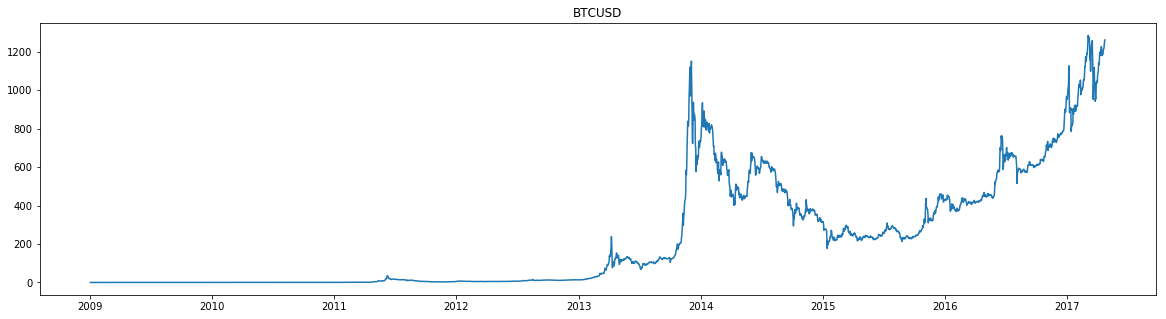

In [331]:
plt.plot(btc_usd_denominated) 
plt.title("BTCUSD")

In [333]:
daterange = pd.date_range('17/8/2010', end='22/4/2017', freq='D')
print(daterange)

DatetimeIndex(['2010-08-17', '2010-08-18', '2010-08-19', '2010-08-20',
               '2010-08-21', '2010-08-22', '2010-08-23', '2010-08-24',
               '2010-08-25', '2010-08-26',
               ...
               '2017-04-13', '2017-04-14', '2017-04-15', '2017-04-16',
               '2017-04-17', '2017-04-18', '2017-04-19', '2017-04-20',
               '2017-04-21', '2017-04-22'],
              dtype='datetime64[ns]', length=2441, freq='D')


In [334]:
dataset = pd.Series(btc_usd_denominated, name="USDBTC", index=daterange) # don't invert this time, let's see

Shapeshift currencies available:

`btc, ltc, ppc, drk, doge, nmc, ftc, blk, nxt, btcd, qrk, rdd, nbt, bts, bitusd, xcp, xmr`

Ethtokens available:

`augur, golem, eth, singular dtv, iconomi`

Quandl data available: 

`btc, ltc, ppc, bts, xcp, xmr`

In [335]:
dataset = pd.Series(ql.get("BTER/LTCBTC", authtoken="6qwbDx25mja4FhBpTfRo")["Average"], name="BTER/LTCBTC", index=daterange)

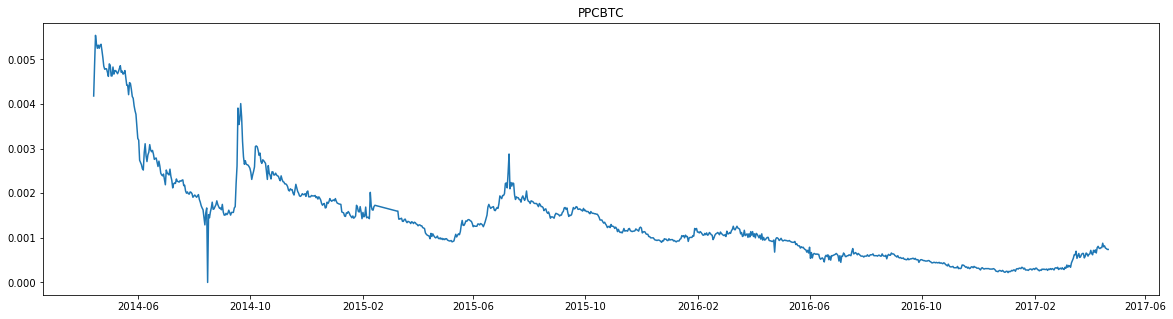

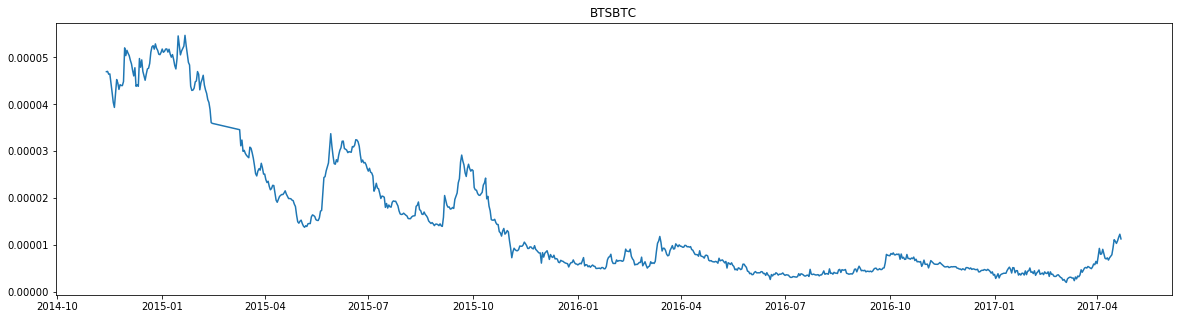

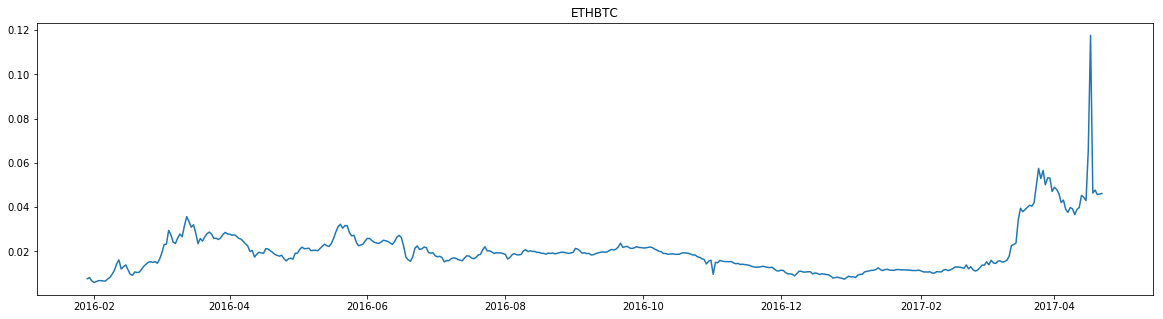

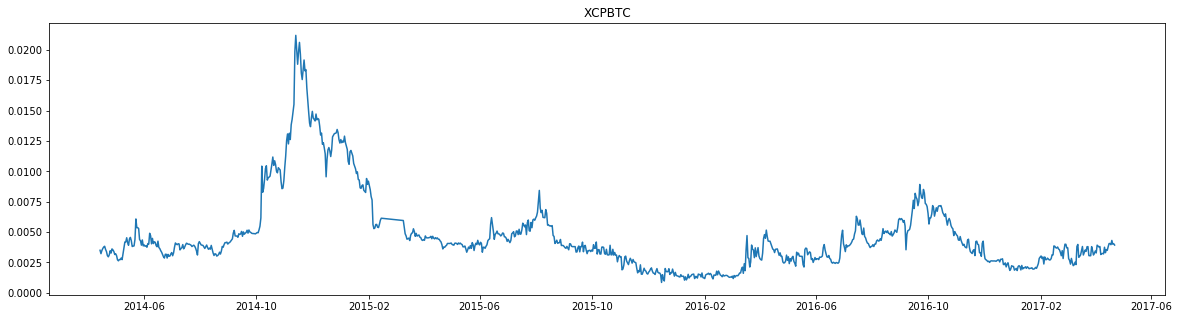

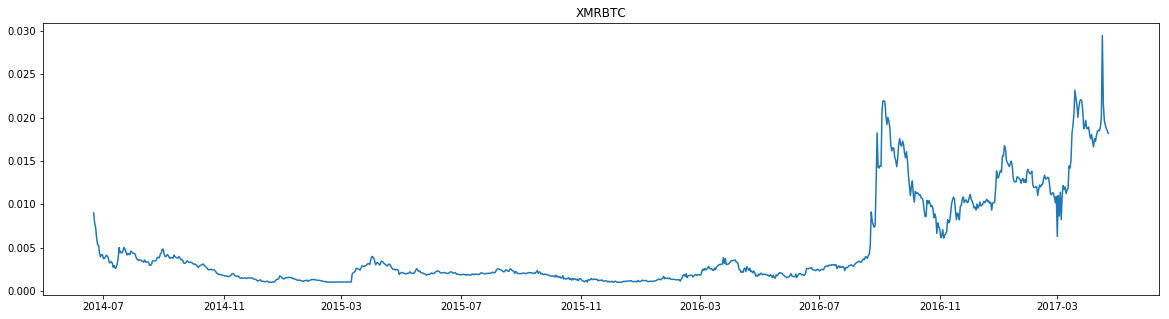

In [263]:
test = ["BTER/PPCBTC","BTER/BTSBTC","BTER/ETHBTC","BTER/XCPBTC","BTER/XMRBTC"]
#test = ["BTER/LTCBTC", "BTER/PPCBTC","BTER/BTSBTC","BTER/ETHBTC","BTER/XCPBTC","BTER/XMRBTC"]


for crypto in test:
    response = ql.get(crypto, authtoken="6qwbDx25mja4FhBpTfRo")["Average"]
    plt.plot(response)
    plt.title(crypto[-6:])
    plt.show()
    additional = pd.Series(response, name=crypto[-6:])
    dataset = pd.concat([dataset, additional], axis=1)

Local store just in case.

In [264]:
dataset.to_csv("crypto_currencies.csv")

In [265]:
dataset.describe()

,BTER/LTCBTC,PPCBTC,BTSBTC,ETHBTC,XCPBTC,XMRBTC
count,1068.000000,1068.000000,862.000000,447.000000,1067.000000,1000.000000
mean,0.009358,0.001375,0.000015,0.019933,0.004641,0.004872
std,0.004449,0.000995,0.000014,0.010652,0.003158,0.005159
min,0.003130,0.000000,0.000002,0.005923,0.000850,0.000971
25%,0.006338,0.000620,0.000005,0.012804,0.002925,0.001723
50%,0.008110,0.001140,0.000008,0.018754,0.003860,0.002431
75%,0.011128,0.001750,0.000020,0.022474,0.004935,0.004856
max,0.026240,0.005540,0.000055,0.117659,0.021200,0.029487


# Cleanup

### Prep

Drop any `NA` or zeroes.

In [266]:
dataset = dataset.dropna()
dataset = dataset.replace(to_replace=0, value=np.exp(10**-10)) # not zero, but normalized_dataset

In [267]:
dataset.describe()

,BTER/LTCBTC,PPCBTC,BTSBTC,ETHBTC,XCPBTC,XMRBTC
count,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000
mean,0.006390,0.000620,0.000006,0.019933,0.003602,0.008200
std,0.001738,0.000285,0.000002,0.010652,0.001570,0.006174
min,0.003130,0.000220,0.000002,0.005923,0.001140,0.001123
25%,0.005005,0.000340,0.000004,0.012804,0.002515,0.002443
50%,0.006330,0.000590,0.000005,0.018754,0.003300,0.008209
75%,0.007815,0.000820,0.000007,0.022474,0.004320,0.012594
max,0.012460,0.001260,0.000012,0.117659,0.008920,0.029487


## Returns

Transform to percent return.

In [268]:
return_dataset = dataset/dataset.shift()

In [269]:
return_dataset.describe()

,BTER/LTCBTC,PPCBTC,BTSBTC,ETHBTC,XCPBTC,XMRBTC
count,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000
mean,1.001394,1.001946,1.005814,1.008284,1.009418,1.011176
std,0.038825,0.078030,0.100826,0.093089,0.129190,0.109922
min,0.846316,0.683544,0.752355,0.394368,0.611465,0.575443
25%,0.989812,0.963294,0.954461,0.974366,0.945168,0.964681
50%,0.998395,1.000000,0.999425,0.999767,0.996710,1.002522
75%,1.006327,1.033333,1.045409,1.033904,1.049277,1.040647
max,1.541766,1.411765,1.454819,1.786447,1.950549,1.752919


### Normalize

In [270]:
normalized_dataset = return_dataset.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))

In [271]:
normalized_dataset.describe()

,BTER/LTCBTC,PPCBTC,BTSBTC,ETHBTC,XCPBTC,XMRBTC
count,4.460000e+02,4.460000e+02,4.460000e+02,4.460000e+02,4.460000e+02,4.460000e+02
mean,-4.847891e-16,-3.177957e-16,1.036789e-16,4.264313e-16,3.841596e-16,2.662606e-16
std,5.582661e-02,1.071521e-01,1.435314e-01,6.687024e-02,9.647611e-02,9.335386e-02
min,-2.229903e-01,-4.372322e-01,-3.608142e-01,-4.410060e-01,-2.971827e-01,-3.700573e-01
25%,-1.665478e-02,-5.307739e-02,-7.310393e-02,-2.436461e-02,-4.798015e-02,-3.948759e-02
50%,-4.313208e-03,-2.671840e-03,-9.095090e-03,-6.117993e-03,-9.489525e-03,-7.349932e-03
75%,7.091999e-03,4.310185e-02,5.636497e-02,1.840406e-02,2.976599e-02,2.502849e-02
max,7.770097e-01,5.627678e-01,6.391858e-01,5.589940e-01,7.028173e-01,6.299427e-01


## Resampling

**Test**: Does upsampling and interpolating the data to a lower timeframe improve performance at all?

In [304]:
unsampled_dataset = normalized_dataset.resample('T')

In [305]:
unsampled_dataset.head()

/Users/v/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: 
.resample() is now a deferred operation
You called head(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  if __name__ == '__main__':


,BTER/LTCBTC,PPCBTC,BTSBTC,ETHBTC,XCPBTC,XMRBTC
2016-01-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-29 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-29 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-29 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-29 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN


In [306]:
interpolated_dataset = unsampled_dataset.interpolate(method='linear').bfill()

In [307]:
interpolated_dataset.head() # Neat

,BTER/LTCBTC,PPCBTC,BTSBTC,ETHBTC,XCPBTC,XMRBTC
2016-01-29 00:00:00,-0.005529,0.03224,0.09003,0.039512,-0.181129,0.053659
2016-01-29 00:01:00,-0.005529,0.03224,0.09003,0.039512,-0.181129,0.053659
2016-01-29 00:02:00,-0.005529,0.03224,0.09003,0.039512,-0.181129,0.053659
2016-01-29 00:03:00,-0.005529,0.03224,0.09003,0.039512,-0.181129,0.053659
2016-01-29 00:04:00,-0.005529,0.03224,0.09003,0.039512,-0.181129,0.053659


Make this the final dataset for testing. Remove if failure.

In [308]:
final_dataset = interpolated_dataset

In [309]:
final_dataset.describe()

,BTER/LTCBTC,PPCBTC,BTSBTC,ETHBTC,XCPBTC,XMRBTC
count,646561.000000,646561.000000,646561.000000,646561.000000,646561.000000,646561.000000
mean,-0.000148,-0.000139,0.000218,-0.000012,-0.000323,0.000286
std,0.045317,0.077091,0.109263,0.054606,0.076153,0.072636
min,-0.222990,-0.437232,-0.360814,-0.441006,-0.297183,-0.370057
25%,-0.013849,-0.039820,-0.057333,-0.021811,-0.037973,-0.033306
50%,-0.004682,-0.004882,-0.010368,-0.006965,-0.007995,-0.007540
75%,0.004848,0.030471,0.045617,0.015423,0.023769,0.021960
max,0.777010,0.562768,0.639186,0.558994,0.702817,0.629943


### Comparison

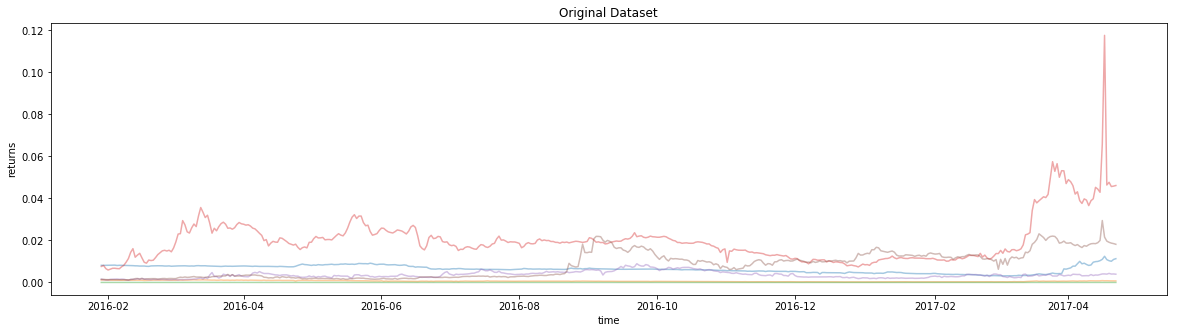

In [310]:
plt.plot(dataset, alpha=.4);

plt.xlabel('time')
plt.ylabel('returns')
plt.title("Original Dataset")
plt.show()

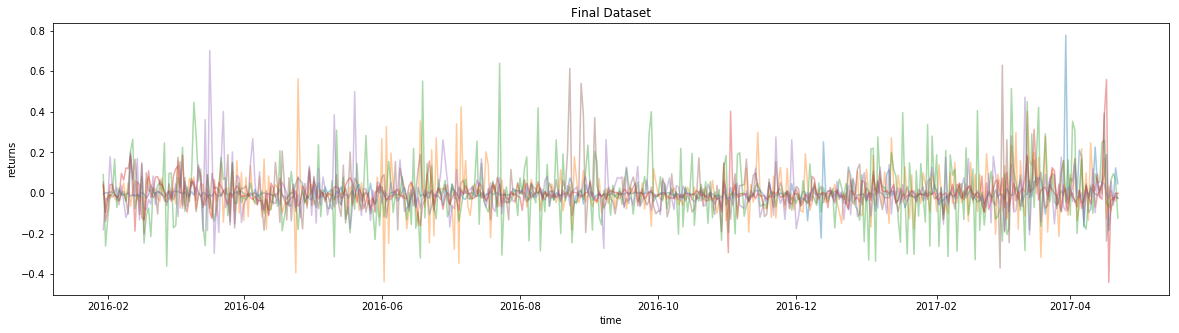

In [311]:
plt.plot(normalized_dataset, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')
plt.title("Final Dataset")
plt.show()

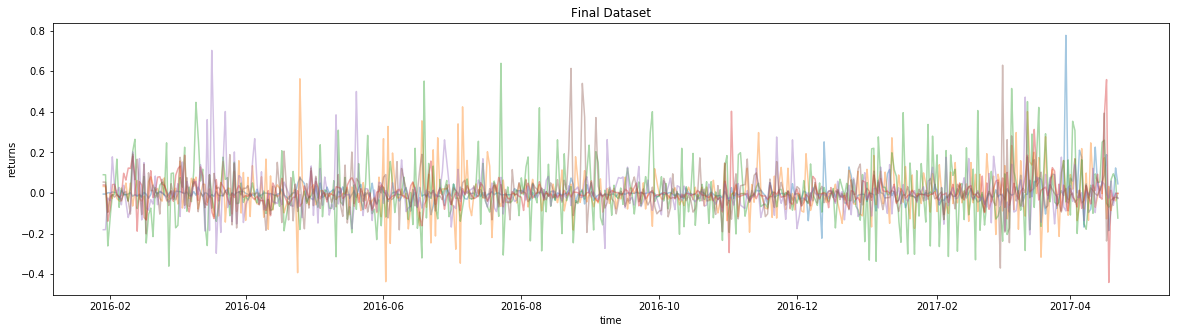

In [312]:
plt.plot(final_dataset, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')
plt.title("Final Dataset")
plt.show()

### Covariance

In [313]:
cov = final_dataset.cov()

In [314]:
cov

,BTER/LTCBTC,PPCBTC,BTSBTC,ETHBTC,XCPBTC,XMRBTC
BTER/LTCBTC,0.002054,0.000164,0.000541,0.000417,-0.000096,0.000167
PPCBTC,0.000164,0.005943,0.001188,0.000342,-0.000026,0.000786
BTSBTC,0.000541,0.001188,0.011938,0.000975,0.000969,0.000579
ETHBTC,0.000417,0.000342,0.000975,0.002982,0.000100,0.000507
XCPBTC,-0.000096,-0.000026,0.000969,0.000100,0.005799,0.000327
XMRBTC,0.000167,0.000786,0.000579,0.000507,0.000327,0.005276


## Perfectly Normal Example

In [315]:
## Example number of assets
n_assets = 4

## NUMBER OF OBSERVATIONS
n_obs = 1000

return_vec = np.random.randn(n_assets, n_obs)

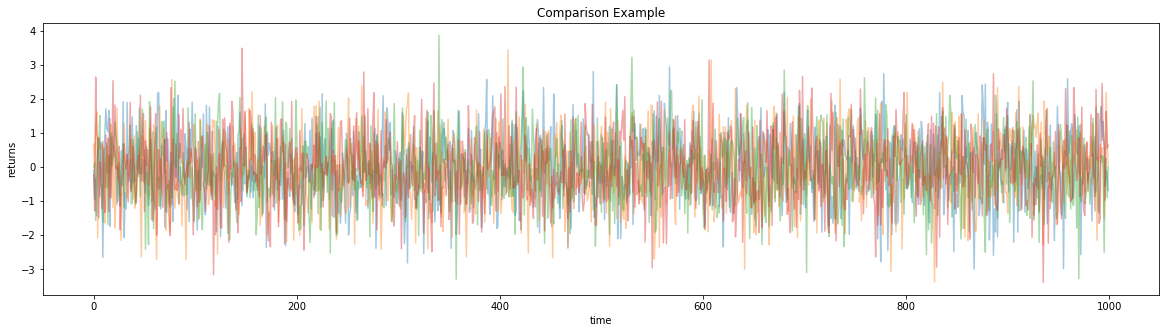

In [316]:
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')
plt.title("Comparison Example")
plt.show()

In [317]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

In [318]:
def old_random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
 
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)

    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return old_random_portfolio(returns)
    return mu, sigma

In [319]:
n_portfolios = 500 # Samples

old_means, old_stds = np.column_stack([
    old_random_portfolio(return_vec) 
    for _ in range(n_portfolios)
])

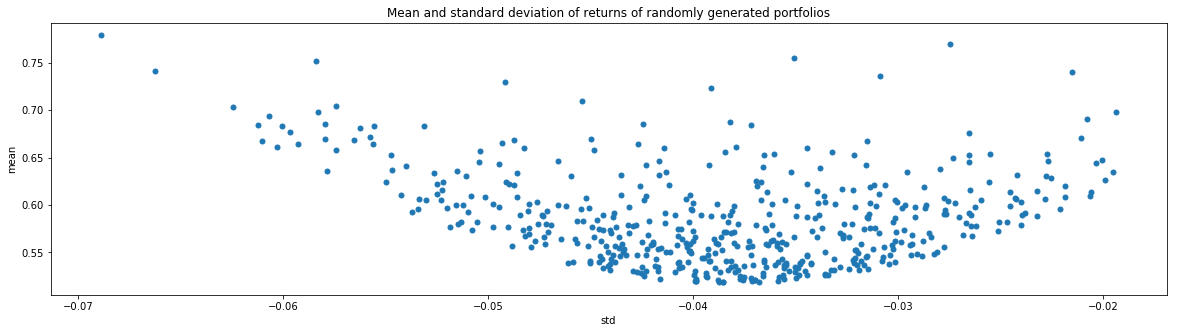

In [320]:
plt.plot(old_means, old_stds, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')
plt.autoscale(False)

In [321]:
def old_optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
        
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    
    #return numpy.asarray(wt), returns, risks
    return np.asarray(wt), returns, risks

old_optimal_portfolio(return_vec)

(array([[  3.72524461e-01],
        [  1.54332431e-08],
        [  1.69370802e-05],
        [  6.27458587e-01]]),
 [-0.017378015217913656,
  -0.01815096703531973,
  -0.018839992801266175,
  -0.019453608257991847,
  -0.020001885818609184,
  -0.021282371719413613,
  -0.02310807630690158,
  -0.024735988374016655,
  -0.026186653837580603,
  -0.02747962435829398,
  -0.028631999879474082,
  -0.029659059534752178,
  -0.03057442893028915,
  -0.03139025340450799,
  -0.032117395756196175,
  -0.03276541382270689,
  -0.03334296527607441,
  -0.03385771088731435,
  -0.03431647976939847,
  -0.03472535881366941,
  -0.03508977313640637,
  -0.035414558046535025,
  -0.035704023106828894,
  -0.03596200924833867,
  -0.03619193972692606,
  -0.03639686553850533,
  -0.036579505896991285,
  -0.03674228431164259,
  -0.03688736074209973,
  -0.037016660257419634,
  -0.03713189857906971,
  -0.03723460484659554,
  -0.03732614190766375,
  -0.03740772440203932,
  -0.03748043487882617,
  -0.037545238161104964,
  -0.03

Run the convex solver.

In [322]:
old_weights, old_returns, old_risks = old_optimal_portfolio(return_vec)

Demonstrate the perfect frontier.

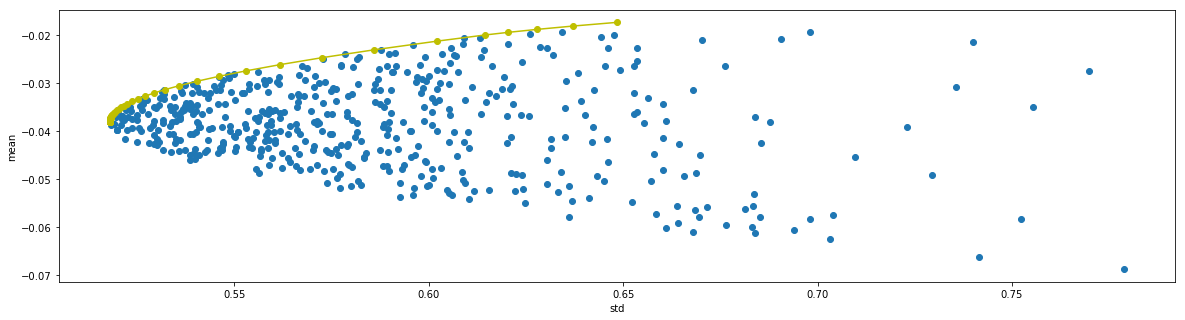

In [323]:
plt.plot(old_stds, old_means, 'o')
plt.ylabel('mean')
plt.xlabel('std')

plt.plot(old_risks, old_returns, 'y-o')
plt.autoscale(False)
plt.show()

Weights that achieve this:

In [324]:
np.round(old_weights, decimals=4) * 100

array([[ 37.25],
       [  0.  ],
       [  0.  ],
       [ 62.75]])

# Actual

Now with our **not perfecly normally distributed** but sanitized crpyo dataset. 

In [325]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(returns.mean())
    w = np.asmatrix(rand_weights(len(returns.mean())))
    C = np.asmatrix(returns.cov())

    mu = w * p.T # mean 
    
    print("\n",p)
    print("\n",w)
    print("\n",C)
    print("\n",mu)
    
    sigma = np.sqrt(w * C * w.T) # standard deviation

    return mu, sigma

In [326]:
n_portfolios = 500

means, stds = np.column_stack([
    random_portfolio(final_dataset) 
    for _ in range(n_portfolios)
])


 [[ -1.48227475e-04  -1.39229888e-04   2.17722604e-04  -1.16246349e-05
   -3.23361285e-04   2.86389824e-04]]

 [[ 0.23125281  0.12568668  0.05634737  0.1653491   0.20086928  0.22049476]]

 [[  2.05365418e-03   1.63839808e-04   5.40537646e-04   4.17295778e-04
   -9.59211260e-05   1.66561424e-04]
 [  1.63839808e-04   5.94302813e-03   1.18827142e-03   3.41519303e-04
   -2.64350147e-05   7.85878913e-04]
 [  5.40537646e-04   1.18827142e-03   1.19384061e-02   9.75017307e-04
    9.69393350e-04   5.79421301e-04]
 [  4.17295778e-04   3.41519303e-04   9.75017307e-04   2.98178908e-03
    9.97735756e-05   5.07147006e-04]
 [ -9.59211260e-05  -2.64350147e-05   9.69393350e-04   9.97735756e-05
    5.79934166e-03   3.27384552e-04]
 [  1.66561424e-04   7.85878913e-04   5.79421301e-04   5.07147006e-04
    3.27384552e-04   5.27598311e-03]]

 [[ -4.32372841e-05]]

 [[ -1.48227475e-04  -1.39229888e-04   2.17722604e-04  -1.16246349e-05
   -3.23361285e-04   2.86389824e-04]]

 [[ 0.15626135  0.29283803  0.008

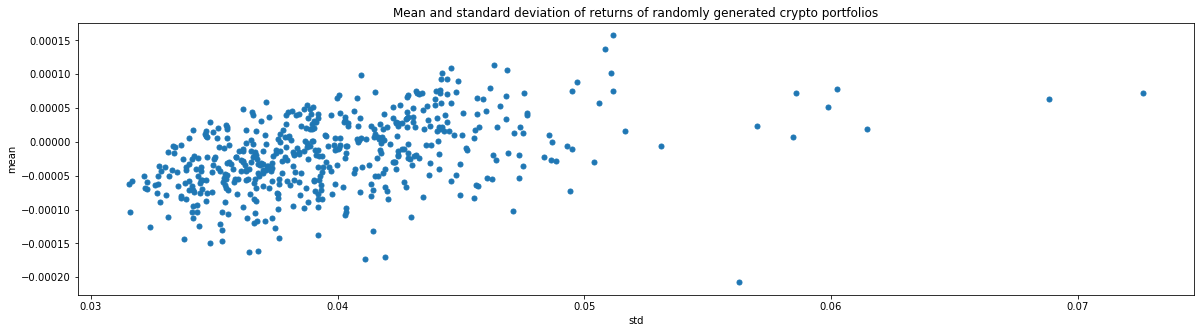

In [327]:
plt.plot(stds, means, 'o', markersize=5)

plt.xlabel('std')
plt.ylabel('mean')

plt.title('Mean and standard deviation of returns of randomly generated crypto portfolios')

In [328]:
def optimal_portfolio(returns):
    n = len(returns.columns)
    return_matrix = np.asmatrix(returns)
    
    N = 100 # Portfolios
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)] # Averags
     
    # Convert to cvxopt matrices
    S = opt.matrix(np.asmatrix(returns.cov()))
    
    pbar = opt.matrix(returns.mean())
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
        
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
        
    return np.asarray(wt), returns, risks

optimal_portfolio(final_dataset)

(array([[  7.59764198e-06],
        [  8.07879637e-06],
        [  8.68300692e-04],
        [  2.35216014e-05],
        [  3.42524778e-06],
        [  9.99089076e-01]]),
 [0.00024457260356457763,
  0.0002294149390209885,
  0.00021588336998630697,
  0.00020308870245758643,
  0.0001854248473454416,
  0.0001637488905157575,
  0.00014391219758720306,
  0.00012564069354520694,
  0.000108306753744476,
  9.230254835567877e-05,
  7.716704841768436e-05,
  6.1006290355692396e-05,
  4.473072876502642e-05,
  2.999251621301072e-05,
  1.6788939718302443e-05,
  5.114577824876778e-06,
  -5.314401784515892e-06,
  -1.4609941141986143e-05,
  -2.289158945085873e-05,
  -3.0268512651295664e-05,
  -3.690445982253447e-05,
  -4.277751074596863e-05,
  -4.801182401717689e-05,
  -5.267686522107488e-05,
  -5.683454742006677e-05,
  -6.05400529052178e-05,
  -6.384254940389238e-05,
  -6.678587923214741e-05,
  -6.940912747114232e-05,
  -7.174712000720775e-05,
  -7.383089385377987e-05,
  -7.56880311415394e-05,
  -7.734

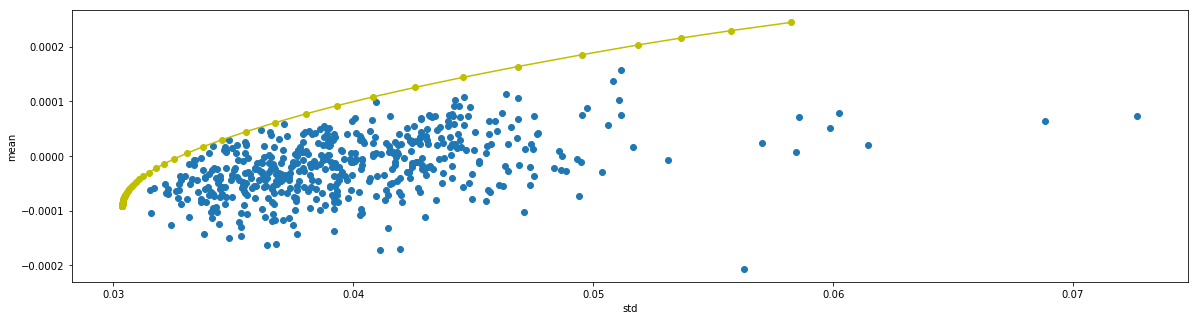

In [329]:
weights, returns, risks = optimal_portfolio(final_dataset)

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')

plt.plot(risks, returns, 'y-o')
plt.autoscale(False)

In [330]:
np.round(weights, decimals=3) * 100

# Convert weights into actual purchase percentages

array([[  0. ],
       [  0. ],
       [  0.1],
       [  0. ],
       [  0. ],
       [ 99.9]])

## Firebase